# Feature Extraction – Synthetic Data

Approach:
- Create synthetic drilling data
- Add noise of some characteristic to the data
- Use PCA to see if there are any clusters
- Create new, independent synthetic data
- Add same noise in different termporal locations in the signal 
- Use same PCA scores and look for similar clusters

### Create Synthetic Data

In [393]:
import numpy as np
import matplotlib.pyplot as plt

n = 500
t = np.arange(1, n+1)
trend = 2 + 0.01 * t
seasonal = np.sin(2 * np.pi * t / 12)
cyclical = np.sin(2 * np.pi * t / 60)
irregular = np.random.randn(n)
y = trend + seasonal + cyclical #+ irregular

In [394]:
# Create random characteristic noise
noise_size = 60
n_noises = 5
noise_frequencies = np.random.randn(n_noises)
sigmas = np.random.randn(n_noises)
mus = np.random.randn(n_noises)
t_noises = []
for _ in range(n_noises):
    t_noise = [int(np.random.uniform(0, n - noise_size))]
    t_noise.append(t_noise[0] + noise_size)
    t_noises.append(range(t_noise[0], t_noise[1]))
noises = [sigma * np.random.rand(noise_size) + mu for sigma, mu in zip(sigmas, mus)]

In [395]:
y_noise = y.copy()
for t_noise, noise in zip(t_noises, noises):
    y_noise[t_noise] = y_noise[t_noise] + noise
        

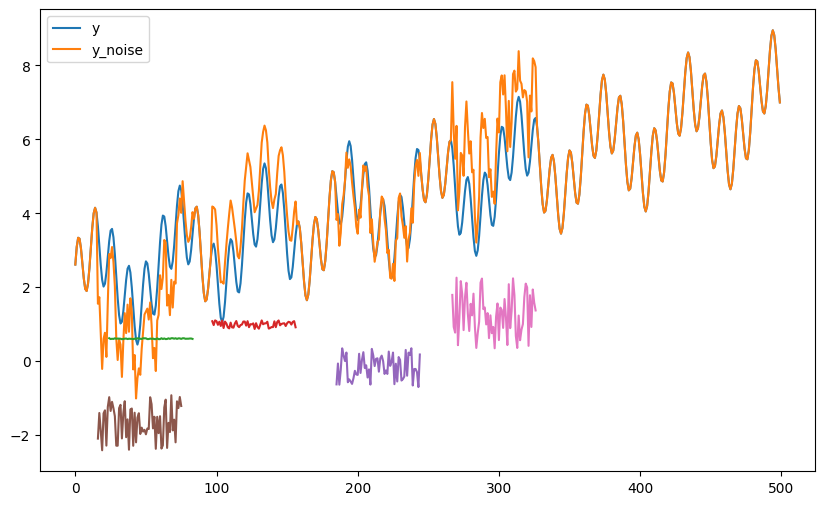

In [396]:
plt.subplots(figsize=(10, 6))
plt.plot(y, label="y")
plt.plot(y_noise, label="y_noise")
#plt.plot(trend, label="trend")
#plt.plot(seasonal, label="seasonal")
#plt.plot(cyclical, label="cyclical")
#plt.plot(irregular, label="irregular")
for t_noise, noise in zip(t_noises, noises):
    plt.plot(t_noise, noise)
plt.legend()

In [397]:
from PyEMD import EMD, Visualisation

emd = EMD()
IMFs = emd(y_noise)

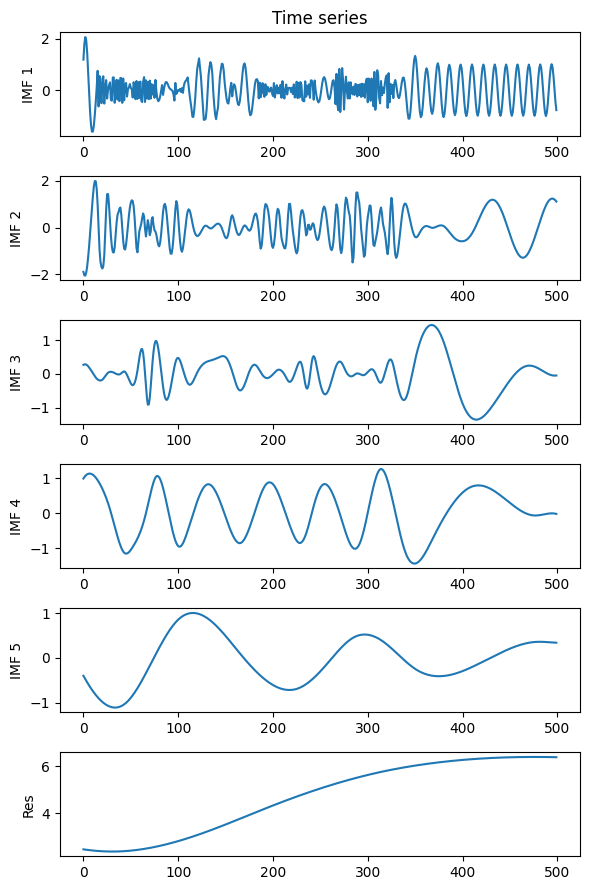

In [398]:
Visualisation(emd).plot_imfs()

In [399]:
import librosa
import pandas as pd

def get_features(y):
    ft1 = librosa.feature.zero_crossing_rate(y=y)[0]
    ft2 = librosa.feature.spectral_rolloff(y=y)[0]
    ft3 = librosa.feature.spectral_centroid(y=y)[0]
    ft4 = librosa.feature.spectral_contrast(y=y)[0]
    ft5 = librosa.feature.spectral_bandwidth(y=y)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(y), np.std(y), np.max(y), np.median(y), np.min(y)))
    
    ### Spectral Features 
    ft1_trunc = np.hstack((np.mean(ft1), np.std(ft1), np.max(ft1), np.median(ft1), np.min(ft1)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), np.max(ft5), np.median(ft5), np.max(ft5)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc)))

def get_column_names(selected_imfs):
    base = "IMF"
    features = ["mean", "std", "max", "median", "min"]
    others = ['zcr', 'spec_roll_off' , 'spec_centroid', 'spec_contrast', 'spec_bandwidth']

    names = []
    for idx in selected_imfs:
        for feature in features:
            names.append(base + f"_{idx}_" + feature)
        for other in others:
            for feature in features:
                names.append(base + f"_{idx}_" + other + "_" + feature)
    return names

In [400]:
from gtda.time_series import SlidingWindow

window = SlidingWindow(size=50, stride = 5)

y_windows = window.fit_transform(y)
t_windows = window.fit_transform(t)

In [401]:
from scipy.signal import cwt, daub

all_features = pd.DataFrame()
selected_imfs = [1, 2, 3, 4]
for window in y_windows:
    IMFs = emd(window)
    features = pd.DataFrame()
    for idx in selected_imfs:
        if idx < len(IMFs):
            features = pd.concat([features, get_features(IMFs[idx])], axis=0)
        else:
            features = pd.concat([features, get_features(np.zeros_like(IMFs[0]))], axis=0)
    for idx in selected_imfs:
        dwt = daub(IMFs[0], wavelet="")
        if idx < len(IMFs):
            features = pd.concat([features, get_features(IMFs[idx])], axis=0)
        else:
            features = pd.concat([features, get_features(np.zeros_like(IMFs[0]))], axis=0)

    all_features = pd.concat([all_features, features.T])

/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=50
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=50
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=50
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=50
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=50
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/

In [402]:
all_features.columns = get_column_names(selected_imfs=selected_imfs)

In [403]:
all_features

,IMF_1_mean,IMF_1_std,IMF_1_max,IMF_1_median,IMF_1_min,IMF_1_zcr_mean,IMF_1_zcr_std,IMF_1_zcr_max,IMF_1_zcr_median,IMF_1_zcr_min,...,IMF_4_spec_contrast_mean,IMF_4_spec_contrast_std,IMF_4_spec_contrast_max,IMF_4_spec_contrast_median,IMF_4_spec_contrast_min,IMF_4_spec_bandwidth_mean,IMF_4_spec_bandwidth_std,IMF_4_spec_bandwidth_max,IMF_4_spec_bandwidth_median,IMF_4_spec_bandwidth_min
0,-0.145356,0.414100,0.510797,-0.225710,-0.684446,0.000977,0.0,0.000977,0.000977,0.000977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2.285563,0.660657,3.089573,2.247492,1.510427,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.142855,0.412248,0.684446,0.225710,-0.510797,0.000977,0.0,0.000977,0.000977,0.000977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2.218693,0.565900,3.090906,2.243157,1.407557,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.061115,0.524326,0.835666,0.123954,-0.707280,0.000977,0.0,0.000977,0.000977,0.000977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.142855,0.412248,0.684446,0.225710,-0.510797,0.000977,0.0,0.000977,0.000977,0.000977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,6.418693,0.565900,7.290906,6.443157,5.607557,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.061115,0.524326,0.835666,0.123954,-0.707280,0.000977,0.0,0.000977,0.000977,0.000977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,6.542471,0.751615,7.939844,6.428850,5.612938,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [404]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(all_features)
scores = pca.fit_transform(all_features)
loadings = pca.components_.T

In [405]:
colors = []
for t_window in t_windows:
    is_in = False
    for t_noise in t_noises:
        if np.all(np.isin(t_window, t_noise)):
            is_in = True
            break
    if is_in:
        colors.append("red")
    else:
        colors.append("blue")

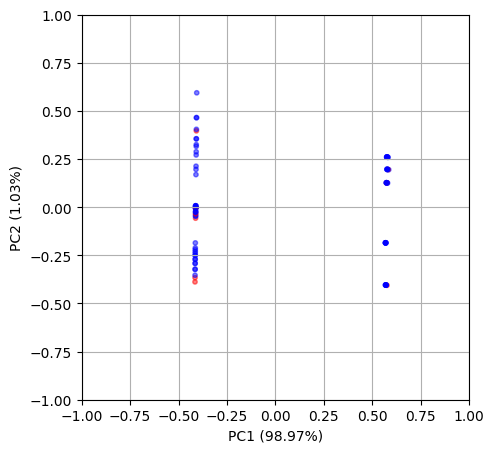

In [406]:
xs = scores[:, 0]
ys = scores[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.scatter(xs * scalex,ys * scaley, s=10, alpha=0.5, c=colors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")

plt.grid()
plt.show()

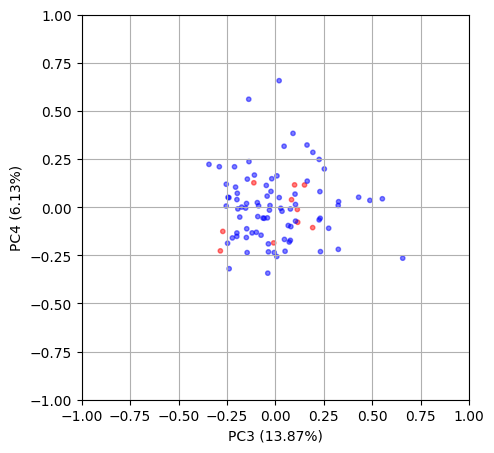

In [392]:
xs = scores[:, 2]
ys = scores[:, 3]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.scatter(xs * scalex,ys * scaley, s=10, alpha=0.5, c=colors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
plt.ylabel(f"PC4 ({pca.explained_variance_ratio_[3]*100:.2f}%)")

plt.grid()
plt.show()

In [137]:
from scipy.fft import fft, fftfreq, fftshift

# Calculate values of x after fft
x_fft = fftfreq(n, 1)
x_fft = fftshift(x_fft)

# Take the FFT of all IMFs
y_noise_ffts = []
for imf in IMFs:
    y_noise_ffts.append(fftshift(fft(imf)))

In [115]:
seasonal_fft = fft(seasonal)
seasonal_fft = fftshift(seasonal_fft)

cyclical_fft = fft(cyclical)
cyclical_fft = fftshift(cyclical_fft)

irregular_fft = fft(irregular)
irregular_fft = fftshift(irregular_fft)

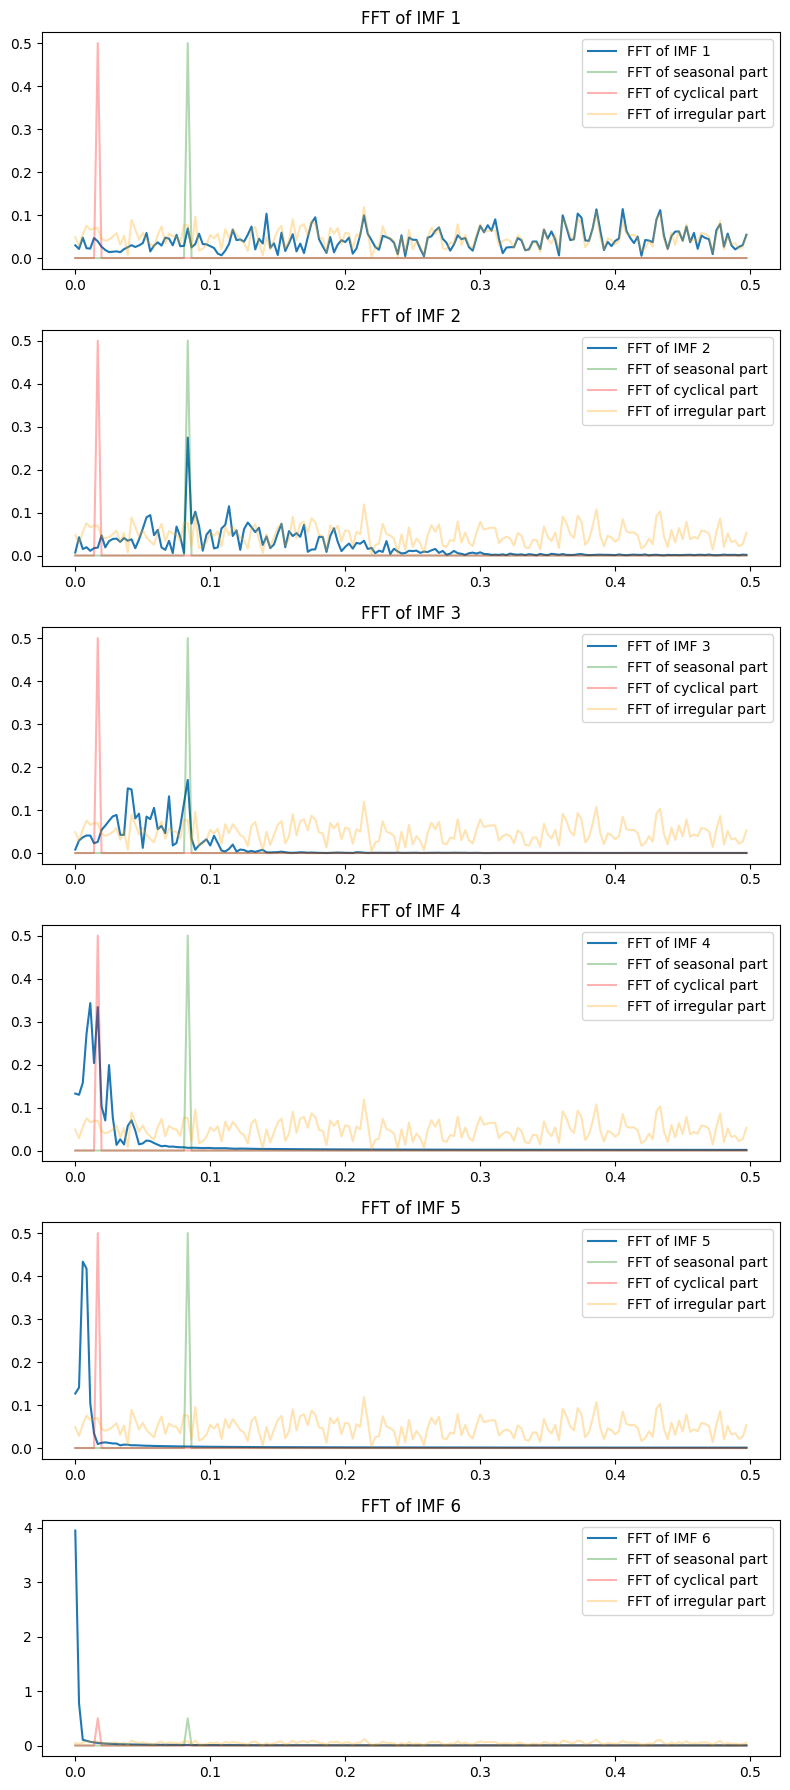

In [116]:
plt.subplots(len(y_noise_ffts), 1, figsize=(8, 3 * len(y_noise_ffts)))
for i, y_fft in enumerate(y_noise_ffts):
    plt.subplot(len(y_noise_ffts), 1, i+1)
    plt.plot(x_fft[n//2:], 1/n * abs(y_fft[n//2:]), label=f"FFT of IMF {i+1}")
    plt.plot(x_fft[n//2:], 1/n * abs(seasonal_fft[n//2:]), label="FFT of seasonal part", color="green", alpha=0.3)
    plt.plot(x_fft[n//2:], 1/n * abs(cyclical_fft[n//2:]), label="FFT of cyclical part", color="red", alpha=0.3)  
    plt.plot(x_fft[n//2:], 1/n * abs(irregular_fft[n//2:]), label="FFT of irregular part", color="orange", alpha=0.3) 
    plt.title(f"FFT of IMF {i+1}")
    plt.legend()
plt.tight_layout()

## Compute IMFs

In [50]:
from PyEMD import EMD, Visualisation

# Calculate IMFs of y
emd = EMD()
IMFs = emd(y)

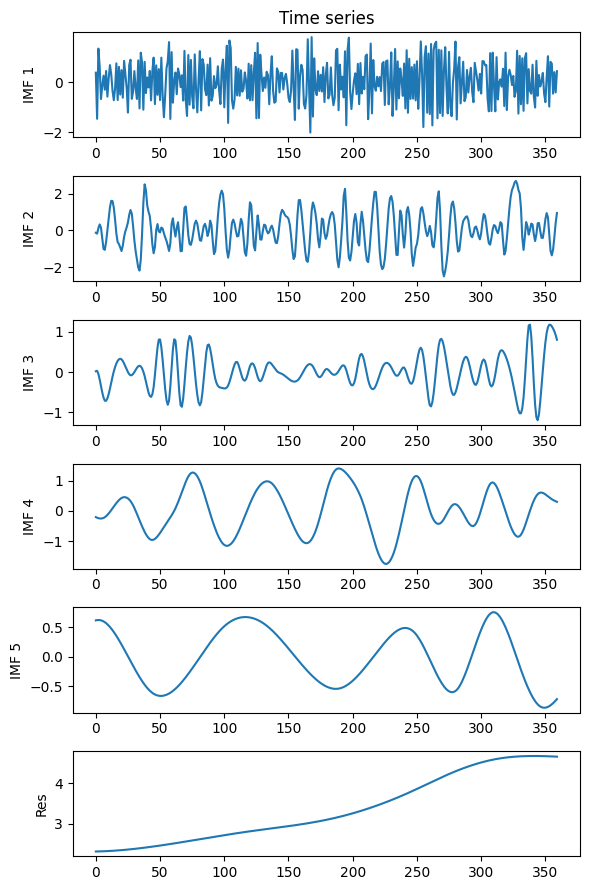

In [51]:
# Plot IMFs using built in visualization functionality
Visualisation(emd).plot_imfs()

## Calculate FFT of IMFs

In [52]:
from scipy.fft import fft, fftfreq, fftshift

# Calculate values of x after fft
x_fft = fftfreq(n, 1)
x_fft = fftshift(x_fft)

# Take the FFT of all IMFs
y_ffts = []
for imf in IMFs:
    y_ffts.append(fftshift(fft(imf)))

In [53]:
# Calculate fft of the seasonal and cyclical trend for visualization
seasonal_fft = fft(seasonal)
seasonal_fft = fftshift(seasonal_fft)

cyclical_fft = fft(cyclical)
cyclical_fft = fftshift(cyclical_fft)

irregular_fft = fft(irregular)
irregular_fft = fftshift(irregular_fft)

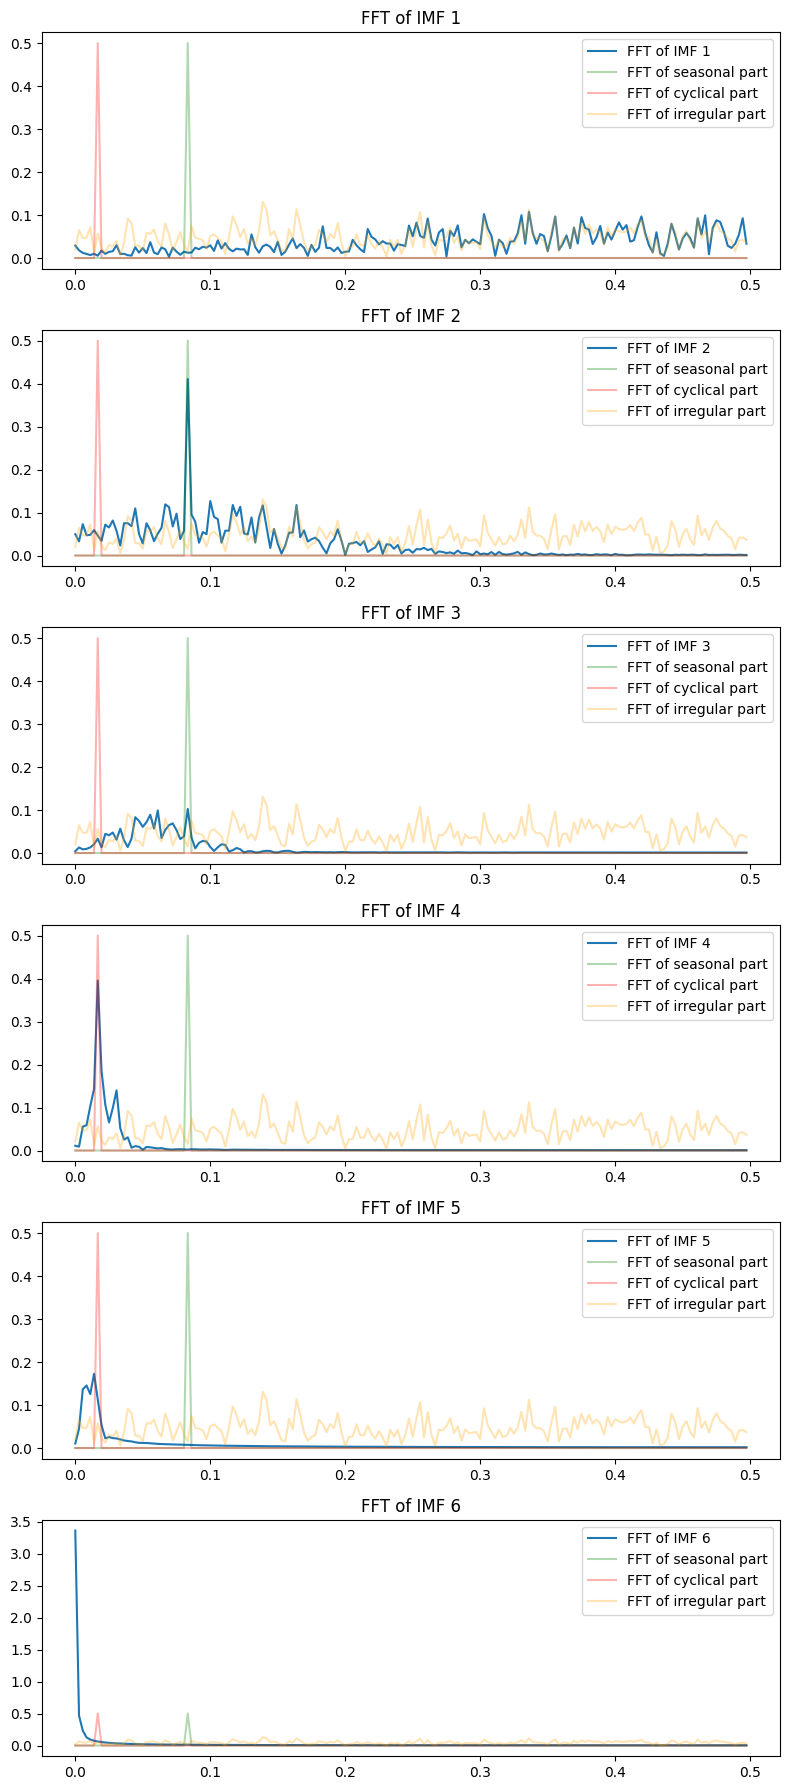

In [54]:
plt.subplots(len(y_ffts), 1, figsize=(8, 3 * len(y_ffts)))
for i, y_fft in enumerate(y_ffts):
    plt.subplot(len(y_ffts), 1, i+1)
    plt.plot(x_fft[n//2:], 1/n * abs(y_fft[n//2:]), label=f"FFT of IMF {i+1}")
    plt.plot(x_fft[n//2:], 1/n * abs(seasonal_fft[n//2:]), label="FFT of seasonal part", color="green", alpha=0.3)
    plt.plot(x_fft[n//2:], 1/n * abs(cyclical_fft[n//2:]), label="FFT of cyclical part", color="red", alpha=0.3)  
    plt.plot(x_fft[n//2:], 1/n * abs(irregular_fft[n//2:]), label="FFT of irregular part", color="orange", alpha=0.3) 
    plt.title(f"FFT of IMF {i+1}")
    plt.legend()
plt.tight_layout()

## Calculate FFT on non-decomposed signal

In [55]:
y_nodecompose_fft = fft(y)
y_nodecompose_fft = fftshift(y_nodecompose_fft)

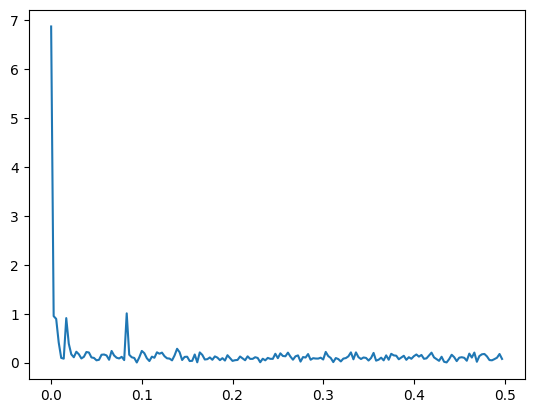

In [56]:
plt.plot(x_fft[n//2:], 2/n * abs(y_nodecompose_fft[n//2:]))

## Remove trend using last IMF and perform FFT

In [57]:
# Remove trend from signal by subtracting the last IMF
y_notrend = y - IMFs[-1]

ValueError: x and y must have same first dimension, but have shapes (2,) and (360,)

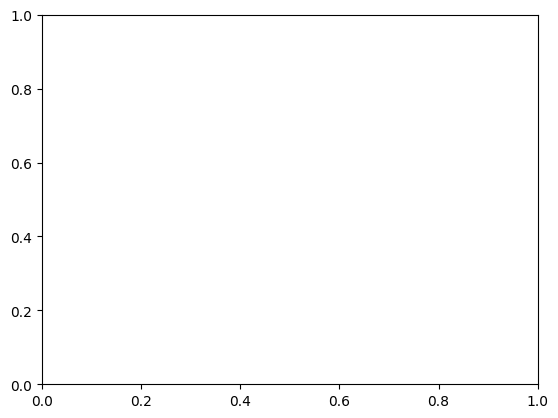

In [58]:
plt.plot(t, y_notrend)

In [ ]:
# Check for stationarity by calculating the mean of different parts of the data

# Split data into 6 parts
split_size = len(y_notrend) / 6

splits = []
for i in range(6):
    splits.append(y_notrend[i*split_size:(i+1)*split_size])

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
y_fft_notrend = fft(y_notrend)
y_fft_notrend = fftshift(y_fft_notrend)

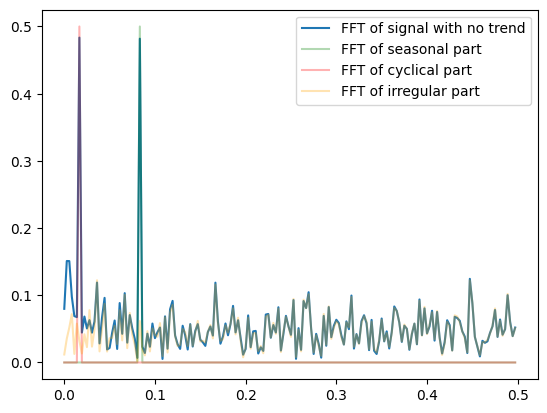

In [ ]:
plt.plot(x_fft[n//2:], 1/n * abs(y_fft_notrend[n//2:]), label="FFT of signal with no trend")
plt.plot(x_fft[n//2:], 1/n * abs(seasonal_fft[n//2:]), label="FFT of seasonal part", color="green", alpha=0.3)
plt.plot(x_fft[n//2:], 1/n * abs(cyclical_fft[n//2:]), label="FFT of cyclical part", color="red", alpha=0.3)  
plt.plot(x_fft[n//2:], 1/n * abs(irregular_fft[n//2:]), label="FFT of irregular part", color="orange", alpha=0.3)
plt.legend()